In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [12]:
fraud = pd.read_csv("../data/raw/Fraud_Data.csv")


In [13]:
fraud["signup_time"] = pd.to_datetime(fraud["signup_time"])
fraud["purchase_time"] = pd.to_datetime(fraud["purchase_time"])

fraud["hour_of_day"] = fraud["purchase_time"].dt.hour
fraud["day_of_week"] = fraud["purchase_time"].dt.dayofweek
fraud["time_since_signup"] = (
    fraud["purchase_time"] - fraud["signup_time"]
).dt.total_seconds()


In [14]:
y = fraud["class"]

X = fraud.drop(columns=["class", "signup_time", "purchase_time"])


In [15]:
cat_cols = ["source", "browser", "sex"]
cat_cols = [c for c in cat_cols if c in X.columns]

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


In [17]:
# 1) See which columns are still non-numeric
non_numeric = X_train.select_dtypes(include=["object"]).columns
print("Non-numeric columns:", list(non_numeric))

# 2) Drop those columns from BOTH train and test
X_train = X_train.drop(columns=non_numeric)
X_test  = X_test.drop(columns=non_numeric)

# (optional) confirm everything is numeric now
print("Dtypes after drop:", X_train.dtypes.unique())


Non-numeric columns: ['device_id']
Dtypes after drop: [dtype('int64') dtype('float64') dtype('int32') dtype('bool')]


In [18]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [19]:
y_train.value_counts(), y_train_res.value_counts()


(class
 0    109568
 1     11321
 Name: count, dtype: int64,
 class
 0    109568
 1    109568
 Name: count, dtype: int64)

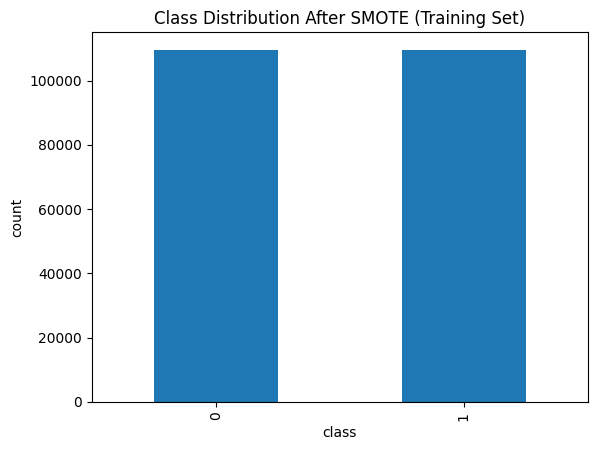

In [20]:
import matplotlib.pyplot as plt

y_train_res.value_counts().plot(kind="bar", title="Class Distribution After SMOTE (Training Set)")
plt.xlabel("class")
plt.ylabel("count")
plt.show()


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

lr = LogisticRegression(max_iter=2000, n_jobs=-1)
lr.fit(X_train_res, y_train_res)

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


[[18933  8460]
 [  929  1901]]
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     27393
           1       0.18      0.67      0.29      2830

    accuracy                           0.69     30223
   macro avg       0.57      0.68      0.54     30223
weighted avg       0.88      0.69      0.75     30223

ROC-AUC: 0.7217566995978828


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


[[26483   910]
 [ 1285  1545]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     27393
           1       0.63      0.55      0.58      2830

    accuracy                           0.93     30223
   macro avg       0.79      0.76      0.77     30223
weighted avg       0.92      0.93      0.93     30223

ROC-AUC: 0.7665835936781457


In [23]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)

gb.fit(X_train_res, y_train_res)

y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_gb))


[[26748   645]
 [ 1303  1527]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     27393
           1       0.70      0.54      0.61      2830

    accuracy                           0.94     30223
   macro avg       0.83      0.76      0.79     30223
weighted avg       0.93      0.94      0.93     30223

ROC-AUC: 0.7687071920955794


In [24]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "roc_auc": "roc_auc",
    "f1": make_scorer(f1_score),
    "recall": make_scorer(recall_score)
}

def cv_report(model, X, y, name="model"):
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"\n{name}")
    print(f"ROC-AUC: {scores['test_roc_auc'].mean():.4f} ± {scores['test_roc_auc'].std():.4f}")
    print(f"F1:      {scores['test_f1'].mean():.4f} ± {scores['test_f1'].std():.4f}")
    print(f"Recall:  {scores['test_recall'].mean():.4f} ± {scores['test_recall'].std():.4f}")

# IMPORTANT: use the resampled train set (balanced) for CV
# X_train_res, y_train_res  (from your SMOTE step)

cv_report(lr, X_train_res, y_train_res, "Logistic Regression")
cv_report(rf, X_train_res, y_train_res, "Random Forest")
cv_report(gb, X_train_res, y_train_res, "Gradient Boosting")



Logistic Regression
ROC-AUC: 0.7379 ± 0.0023
F1:      0.6882 ± 0.0027
Recall:  0.6852 ± 0.0023

Random Forest
ROC-AUC: 0.9672 ± 0.0005
F1:      0.9123 ± 0.0007
Recall:  0.8693 ± 0.0017

Gradient Boosting
ROC-AUC: 0.9274 ± 0.0014
F1:      0.8394 ± 0.0015
Recall:  0.7417 ± 0.0016


In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# ----- Random Forest tuning -----
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_params = {
    "n_estimators": randint(200, 800),
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=rf_params,
    n_iter=20,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train_res, y_train_res)
print("Best RF params:", rf_search.best_params_)
print("Best RF CV ROC-AUC:", rf_search.best_score_)
best_rf = rf_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 720}
Best RF CV ROC-AUC: 0.9623976855051127


In [26]:
# ----- Gradient Boosting tuning -----
gb_base = GradientBoostingClassifier(random_state=42)

gb_params = {
    "n_estimators": randint(100, 400),
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": randint(2, 6),
    "subsample": [0.6, 0.8, 1.0]
}

gb_search = RandomizedSearchCV(
    gb_base,
    param_distributions=gb_params,
    n_iter=20,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

gb_search.fit(X_train_res, y_train_res)
print("Best GB params:", gb_search.best_params_)
print("Best GB CV ROC-AUC:", gb_search.best_score_)
best_gb = gb_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best GB params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 363, 'subsample': 1.0}
Best GB CV ROC-AUC: 0.951377549515923


Model selection narrative 

Logistic Regression performed reasonably and is highly interpretable, but its fraud-class precision/F1 was low compared to ensemble models.

Random Forest and Gradient Boosting improved ROC-AUC and fraud-class F1/precision due to their ability to capture non-linear patterns.

After cross-validation and hyperparameter tuning, the selected model is (best_rf or best_gb) because it achieved the best balance of ROC-AUC, fraud recall, and F1, while remaining stable across folds (low std).

For deployment, interpretability can be added using feature importance / SHAP, while keeping strong predictive performance.

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

final_model = best_rf   # or best_gb

final_model.fit(X_train_res, y_train_res)

y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))


[[26366  1027]
 [ 1277  1553]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     27393
           1       0.60      0.55      0.57      2830

    accuracy                           0.92     30223
   macro avg       0.78      0.76      0.77     30223
weighted avg       0.92      0.92      0.92     30223

Test ROC-AUC: 0.7670628242055597
